In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Global Parameters

In [2]:
SEED = 42
pca_components = 200

## Load the dataset

In [3]:
# Load train.csv
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# Set image directories
train_images_path = './data/train_ims/'
test_images_path = './data/test_ims/'

### Data Augmentation

In [4]:
def apply_color_jitter(image, brightness=0.2, contrast=0.2, saturation=0.2):
    # Convert to HSV for saturation adjustment
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)

    # Adjust brightness
    brightness_factor = 1 + np.random.uniform(-brightness, brightness)
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * brightness_factor, 0, 255)

    # Adjust saturation
    saturation_factor = 1 + np.random.uniform(-saturation, saturation)
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 255)

    # Convert back to RGB
    adjusted_image = cv2.cvtColor(hsv_image.astype(np.uint8), cv2.COLOR_HSV2RGB)

    # Adjust contrast
    contrast_factor = 1 + np.random.uniform(-contrast, contrast)
    mean_pixel = np.mean(adjusted_image, axis=(0, 1), keepdims=True)
    adjusted_image = np.clip((adjusted_image - mean_pixel) * contrast_factor + mean_pixel, 0, 255).astype(np.uint8)

    return adjusted_image

In [5]:
import numpy as np
import cv2

def augment_data(X, y, seed=None):
    if seed is not None:
        np.random.seed(seed)

    augmented_X = [X]  # Start with original images
    augmented_y = [y]  # Start with original labels

    # Horizontal flip
    X_flipped = X[:, :, ::-1, :]  # Horizontal flip
    augmented_X.append(X_flipped)
    augmented_y.append(y)

    # Random rotation
    X_rotated = []
    y_rotated = []
    for img, label in zip(X, y):
        if np.random.rand() < 0.2:
            angle = np.random.uniform(-15, 15)  # Random angle between -15 and 15 degrees
            h, w = img.shape[:2]
            M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
            rotated_img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
            X_rotated.append(rotated_img)
            y_rotated.append(label)
    augmented_X.append(np.array(X_rotated))
    augmented_y.append(np.array(y_rotated))

    # Random Color Jitter (10% chance per image)
    X_jittered = []
    y_jittered = []
    for img, label in zip(X, y):
        if np.random.rand() < 0.1:  # 10% chance for each image
            jittered_img = apply_color_jitter(img, brightness=0.2, contrast = 0.2, saturation = 0.2)
            X_jittered.append(jittered_img)
            y_jittered.append(label)
    augmented_X.append(np.array(X_jittered))
    augmented_y.append(np.array(y_jittered))

    # Random Crop (10% chance per image)
    X_cropped = []
    y_cropped = []
    crop_margin = 16  # Total pixels to crop
    for img, label in zip(X, y):
        if np.random.rand() < 0.1:  # 10% chance for each image
            h, w = img.shape[:2]
            crop_h, crop_w = h - crop_margin, w - crop_margin
            y0 = np.random.randint(0, h - crop_h + 1)
            x0 = np.random.randint(0, w - crop_w + 1)
            cropped_img = img[y0:y0 + crop_h, x0:x0 + crop_w]
            cropped_img = cv2.resize(cropped_img, (w, h))  # Resize back to original dimensions
            X_cropped.append(cropped_img)
            y_cropped.append(label)
    augmented_X.append(np.array(X_cropped))
    augmented_y.append(np.array(y_cropped))

    # Concatenate all augmented data and labels
    X_augmented = np.concatenate(augmented_X, axis=0)
    y_augmented = np.concatenate(augmented_y, axis=0)

    return X_augmented, y_augmented


In [6]:


def read_data(mode="train", p=1.0, augment=False, seed=None, data_dir='./data'):
    if mode == "train":
        csv_path = os.path.join(data_dir, 'train.csv')
        image_dir = os.path.join(data_dir, 'train_ims')
    elif mode in ["test", "predict"]:
        csv_path = os.path.join(data_dir, 'test.csv')
        image_dir = os.path.join(data_dir, 'test_ims')
        mode = "test"  # Ensure uniform handling for "test" and "predict"
    else:
        raise ValueError("mode must be 'train', 'test', or 'predict'")

    # Load the CSV file
    data = pd.read_csv(csv_path)

    # Sample a fraction of the data if p < 1.0
    if mode == "train" and p < 1.0:
        if seed is not None:
            data = data.sample(frac=p, random_state=seed)
        else:
            data = data.sample(frac=p)

    # Load images and labels
    X = []
    for filename in data['im_name']:
        image_path = os.path.join(image_dir, filename)
        img = Image.open(image_path).convert("RGB")  # Convert to RGB
        X.append(np.asarray(img))

    X = np.stack(X)  # Stack into a 4D NumPy array

    if mode == "train":
        y = data['label'].values
        if augment:
            X_agumented, y_augmented = augment_data(X, y, SEED)
            print(f"Original shape: {X.shape}, Augmented shape: {X_agumented.shape}, Augmented labels shape: {y_augmented.shape}")
        return X_agumented, y_augmented
        return X, y
    else:
        return X


In [7]:
X_train, y_train = read_data(mode="train", p=1, augment=True, seed=SEED)

Original shape: (50000, 32, 32, 3), Augmented shape: (119946, 32, 32, 3), Augmented labels shape: (119946,)


In [8]:
# X_train, y_train = prepare_augument_data(X_pre_train, y_pre_train)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

X_train shape: (119946, 32, 32, 3), y_train shape: (119946,)


((95956, 32, 32, 3), (95956,), (23990, 32, 32, 3), (23990,))

## Data Pre-processing

In [9]:
# Resize the image
def resize_images(imgs, size=(128, 128)):
    resized_images = []
    for img in imgs:
        # Resize the image using OpenCV
        resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized)
    return np.array(resized_images)

X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)
X_train_resized.shape, X_val_resized.shape

((95956, 128, 128, 3), (23990, 128, 128, 3))

### Extract Feature

In [10]:
# SIFT feature extraction function
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descriptors = sift.detectAndCompute(gray_image, None)
    if descriptors is None:  # Handle case where no features are detected
        descriptors = np.zeros((1,128))
    return np.mean(descriptors, axis=0)

In [11]:
from skimage.feature import hog
from cv2 import HOGDescriptor

def extract_hog_features(image):
    hog_kwargs = {
        "_winSize": (128, 128),
        "_blockSize": (64, 64),
        "_blockStride": (16, 16),
        "_cellSize": (16, 16),
        "_nbins": 10,
        "_derivAperture": 1,
        "_winSigma": -1,
        "_histogramNormType": 0,
        "_L2HysThreshold": 0.2,
        "_gammaCorrection": True,
        "_nlevels": 64,
        "_signedGradient": True
    }
    hog = HOGDescriptor(**hog_kwargs)

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features = hog.compute(gray_image).flatten()
    return features

In [12]:
def extract_eoh_features(image, cell_size=(8, 8), bins=16):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi)
    orientation[orientation < 0] += 180

    h, w = gray_image.shape
    cell_h, cell_w = cell_size
    histograms = []

    for i in range(0, h, cell_h):
        for j in range(0, w, cell_w):
            cell_magnitude = magnitude[i:i + cell_h, j:j + cell_w]
            cell_orientation = orientation[i:i + cell_h, j:j + cell_w]
            
            hist, _ = np.histogram(
                cell_orientation,
                bins=bins,
                range=(0, 180),
                weights=cell_magnitude
            )
            histograms.append(hist)
    eoh_hist = np.concatenate(histograms)
    norm = np.linalg.norm(eoh_hist)
    if norm > 0:
        eoh_hist /= norm
    return eoh_hist

In [13]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, radius=3, n_points=None, method='uniform'):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if n_points is None:
        n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= hist.sum() + 1e-6  # Add epsilon to avoid division by zero
    return hist


In [14]:
import cv2
import numpy as np

def extract_hist_feature(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bins = 8  # Number of bins in the histogram
    hist_size = [bins, bins, bins]  # Number of bins for each channel
    ranges = [0, 256, 0, 256, 0, 256]  # Range for each channel
    hist = cv2.calcHist([image], [0, 1, 2], None, hist_size, ranges)
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [ ]:
# combine features extracted from SIFT, HOG, EOH and HIST
def combine_feature(image):
    # Extract features using SIFT, HOG, EOH, and HIST
    sift_features = extract_sift_features(image)
    hog_features = extract_hog_features(image)
    eoh_features = extract_eoh_features(image)
    # lbp_features = extract_lbp_features(image)
    hist_features = extract_hist_feature(image)

    # Concatenate features into a single vector
    combined = np.concatenate((sift_features, hog_features, eoh_features, hist_features), axis=0)
    return combined

In [16]:
X_train_features = []
X_val_features = []
for image in X_train_resized:
    combined_features = combine_feature(image)
    X_train_features.append(combined_features)
for image in X_val_resized:
    combined_features = combine_feature(image)
    X_val_features.append(combined_features)
X_train_features = np.array(X_train_features)
X_val_features = np.array(X_val_features)

X_train_features.shape, X_val_features.shape

((95956, 8736), (23990, 8736))

In [17]:
del X_train, X_val

In [18]:
# del X_train_resized, X_val_resized

## Fine-tune PCA and SVM

### Apply PCA

In [19]:
# # feature selection before pca
# from sklearn.feature_selection import SelectKBest, mutual_info_classif
# selector = SelectKBest(mutual_info_classif, k=100)  # Select top 100 features
# X_train_selected = selector.fit_transform(X_train_features, y_train)
# X_val_selected = selector.transform(X_val_features)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_features)
# X_val_scaled = scaler.transform(X_val_features)

# # Apply PCA after feature selection
# pca = PCA(n_components=pca_components)  # Reduce to 100 components
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_val_pca = pca.transform(X_val_scaled)
# X_train_pca.shape, X_val_pca.shape

In [20]:
# del X_train_selected, X_val_selected

## SVM Classifier

In [21]:
# svm_clf = make_pipeline(
#     StandardScaler(),  # Standardize the features
#     SVC(C=7.0, kernel='rbf', gamma='scale', random_state=SEED)  # SVM with RBF kernel
# )
from sklearn.pipeline import Pipeline

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_components)),
    ('svm', SVC(C=2, kernel='rbf', gamma='scale', random_state=SEED))
])

# Fit the model to the training data
svm_clf.fit(X_train_features, y_train)

# Predict on the validation set
y_val_pred = svm_clf.predict(X_val_features)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7758

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      2347
           1       0.88      0.86      0.87      2482
           2       0.72      0.69      0.70      2474
           3       0.61      0.63      0.62      2393
           4       0.72      0.75      0.73      2417
           5       0.71      0.68      0.69      2395
           6       0.82      0.82      0.82      2383
           7       0.83      0.81      0.82      2336
           8       0.86      0.84      0.85      2437
           9       0.85      0.85      0.85      2326

    accuracy                           0.78     23990
   macro avg       0.78      0.78      0.78     23990
weighted avg       0.78      0.78      0.78     23990



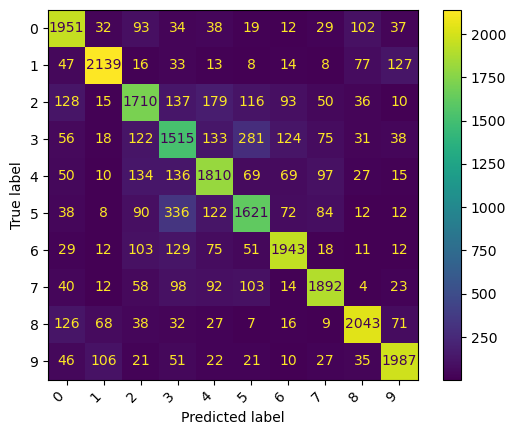

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#confusion matrix for the validation set
color = 'white'
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

## Predict Test Data

In [23]:
from PIL import Image
X_test = read_data(mode="test", data_dir='./data')
X_test_features = []
X_test_resized = resize_images(X_test)
for image in X_test_resized:
    combined_features = combine_feature(image)
    X_test_features.append(combined_features)
X_test_features = np.array(X_test_features)
print(f"Preprocessed test images shape: {X_test_features.shape}")

# Predict labels
y_test_pred = svm_clf.predict(X_test_features)  # Use your trained model

# Save predictions to CSV
test_df['label'] = y_test_pred
submission_file = './submission.csv'
test_df.to_csv(submission_file, index=False)

print(f"Predictions saved to {submission_file}")


Preprocessed test images shape: (10000, 8736)
Predictions saved to ./submission.csv
